## Caffeinated 01 · Sustained Concentration in Long Rallies

### Caffeinated Behavior Framework

"Caffeinated" in this context refers to:
- **Sustained alertness**: Maintaining performance without decay over extended engagement
- **Cognitive endurance**: Effectiveness under tactical complexity and high-load situations

Unlike stimulant effects in humans (which are pharmacological), we use "caffeinated" 
as a behavioral metaphor for sustained high-level functioning without concentration collapse.

### Objective
Quantify Carlos Alcaraz’s **Sustained Concentration** by analyzing match-level performance in long rallies using rally-length metrics and win rates from `data/rally.csv` (≈250 matches).

### Definition
**Sustained Concentration** is the ability to **maintain or improve point-level win probability as rally length increases**, especially in high-cognitive-load exchanges (\(\ge 7\) shots). This captures **persistence of effectiveness**, not physical endurance or match duration.

**Null hypothesis (Caffeinated):** At the professional level, the default expectation is that **win probability approaches equilibrium (≈50%) as rally length increases**—i.e., efficiency should **decay toward 50%** in very long exchanges.

### Key questions
- **Does efficiency decay, stay flat, or improve** when rallies extend into 7–9 and 10+ shot exchanges?  
- **How stable is the efficiency profile** across ≈250 matches?  
- How are long-rally win rates related to **average rally length on serve and return?**  
- How often do we see **episodic dominance** (near-perfect conversion in 10+ shot rallies)?

This notebook implements **Part A: Sustained Concentration (Caffeinated – Engagement Level)** using the provided rally-level summary dataset, focusing on the **shape of efficiency as rallies lengthen**, not the absolute performance level.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use a robust seaborn-compatible style; fall back gracefully if unavailable
try:
    plt.style.use("seaborn-v0_8-whitegrid")
except OSError:
    plt.style.use("seaborn-whitegrid")

sns.set_context("talk")

pd.set_option("display.max_columns", None)

# Notebook is in the project root, so data lives in ./data
DATA_PATH = "data/rally.csv"

print("Pandas version:", pd.__version__)
print("Data path:", DATA_PATH)

Pandas version: 3.0.0
Data path: data/rally.csv


### Step 1 · Load data and parse percentage columns

Dataset assumptions (match-level):
- **`RLen-Serve`**: Average rally length on Alcaraz’s service points.
- **`RLen-Return`**: Average rally length on Alcaraz’s return points.
- **`1-3 W%`, `4-6 W%`, `7-9 W%`, `10+ W%`**: Match-level win percentages for rallies in the respective length buckets.

We will:
- Load `rally.csv`.
- **Normalize column names** (strip whitespace, handle non-breaking spaces).
- **Parse all percentage columns as floats in [0, 1]**.
- Create convenient aliases for the key win-rate columns.

In [2]:
# Load raw data
raw_df = pd.read_csv(DATA_PATH)
print("Raw shape:", raw_df.shape)
print("Raw columns:")
print(list(raw_df.columns))

# Normalize column names: strip spaces and replace non-breaking spaces
clean_cols = []
for c in raw_df.columns:
    if isinstance(c, str):
        c_clean = c.replace("\xa0", " ").strip()
    else:
        c_clean = c
    clean_cols.append(c_clean)

raw_df.columns = clean_cols

# Drop unnamed / empty trailing columns created by extra commas in CSV
unnamed_cols = [c for c in raw_df.columns if isinstance(c, str) and c.startswith("Unnamed")]
if unnamed_cols:
    print("\nDropping unnamed columns:", unnamed_cols)
    raw_df = raw_df.drop(columns=unnamed_cols)

# Identify percentage columns by suffix
pct_cols = [c for c in raw_df.columns if isinstance(c, str) and c.endswith("W%")]
print("\nDetected percentage columns:", pct_cols)

# Helper to convert strings like '55.90%' to float in [0, 1]
def parse_pct(series: pd.Series) -> pd.Series:
    return (
        series.astype(str)
        .str.replace("%", "", regex=False)
        .str.strip()
        .replace({"": np.nan})
        .astype(float)
        / 100.0
    )

# Apply parsing to percentage columns
df = raw_df.copy()
for col in pct_cols:
    df[col] = parse_pct(df[col])

# Coerce numeric types for rally-length columns
for num_col in ["RallyLen", "RLen-Serve", "RLen-Return"]:
    if num_col in df.columns:
        df[num_col] = pd.to_numeric(df[num_col], errors="coerce")

# Create convenient aliases for key win-rate columns
rename_map = {}
for original in pct_cols:
    base = original.replace(" ", "")  # handle e.g. '1-3 W%'
    if base.startswith("1-3"):
        rename_map[original] = "W_1_3"
    elif base.startswith("4-6"):
        rename_map[original] = "W_4_6"
    elif base.startswith("7-9"):
        rename_map[original] = "W_7_9"
    elif base.startswith("10+"):
        rename_map[original] = "W_10_plus"

if rename_map:
    df = df.rename(columns=rename_map)

print("\nCleaned columns:")
print(list(df.columns))
print("\nDtypes:")
print(df.dtypes)

# Quick sanity check
display(df.head())
print("\nWin-rate columns (0–1 scale):", [c for c in df.columns if c.startswith("W_")])

Raw shape: (251, 15)
Raw columns:
['Match', 'Result', 'RallyLen', 'RLen-Serve', 'RLen-Return', '1-3\xa0W%', '4-6\xa0W%', '7-9\xa0W%', '10+\xa0W%', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']

Dropping unnamed columns: ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']

Detected percentage columns: ['1-3 W%', '4-6 W%', '7-9 W%', '10+ W%']

Cleaned columns:
['Match', 'Result', 'RallyLen', 'RLen-Serve', 'RLen-Return', 'W_1_3', 'W_4_6', 'W_7_9', 'W_10_plus']

Dtypes:
Match              str
Result             str
RallyLen       float64
RLen-Serve     float64
RLen-Return    float64
W_1_3          float64
W_4_6          float64
W_7_9          float64
W_10_plus      float64
dtype: object


,Match,Result,RallyLen,RLen-Serve,RLen-Return,W_1_3,W_4_6,W_7_9,W_10_plus
0,2026 Australian Open F,W vs Djokovic,4.3,4.5,4.1,0.496,0.647,0.417,0.545
1,2026 Australian Open R32,W vs Moutet,4.1,3.8,4.3,0.559,0.575,0.737,0.615
2,2025 Tour Finals F,L vs Sinner,3.9,3.7,4.1,0.462,0.625,0.538,0.167
3,2025 Tour Finals SF,W vs Auger Aliassime,3.4,3.0,3.8,0.609,0.444,0.857,0.400
4,2025 Tour Finals RR,W vs De Minaur,4.5,4.1,5.0,0.522,0.500,0.609,0.667



Win-rate columns (0–1 scale): ['W_1_3', 'W_4_6', 'W_7_9', 'W_10_plus']


### Aggregate behavior · Long-rally efficiency profile (7–9 vs 10+)

We quantify the **efficiency profile** in long rallies by computing:
- **Mean 7–9 W%** and **Mean 10+ W%** (match-level averages, 0–1 scale).
- **Standard deviations** across matches for both.

This answers:
- **“On average, where do long-rally win rates sit relative to 50% equilibrium?”**  
- **“How much does that efficiency vary between matches?”**

In [3]:
long_cols = [c for c in ["W_7_9", "W_10_plus"] if c in df.columns]
assert long_cols, "Expected long-rally columns W_7_9 / W_10_plus not found."

long_summary = (
    df[long_cols]
    .agg(["mean", "std"])
    .T
    .rename(columns={"mean": "mean_win_rate", "std": "std_across_matches"})
)

# Avoid using .style to keep dependencies minimal (no jinja2 requirement)
print("Long-rally performance summary (win rates in 0–1 scale):")
print(long_summary.round(3))

print("\nInterpretation (raw numbers in %):")
for col in long_cols:
    m = long_summary.loc[col, "mean_win_rate"] * 100
    s = long_summary.loc[col, "std_across_matches"] * 100
    print(f"  {col}: mean={m:5.1f}%  |  std={s:5.1f} percentage points")

Long-rally performance summary (win rates in 0–1 scale):
           mean_win_rate  std_across_matches
W_7_9              0.552               0.140
W_10_plus          0.569               0.179

Interpretation (raw numbers in %):
  W_7_9: mean= 55.2%  |  std= 14.0 percentage points
  W_10_plus: mean= 56.9%  |  std= 17.9 percentage points


### Aggregate behavior · Decay_Index (short vs long rally efficiency)

The original design references a prior analysis of **Short_Win_Avg vs Long_Win_Avg**. Here we create a **decay-focused metric** using the current dataset:

- **Short-rally win rate (`Short_Win`)**: average of `1-3 W%` and `4-6 W%` (0–6 shots).  
- **Long-rally win rate (`Long_Win`)**: average of `7-9 W%` and `10+ W%` (7+ shots).

For each match we compute a **Decay_Index**:
- **`Decay_Index = Long_Win − Short_Win`**.

We then summarize:
- **Mean Decay_Index** across matches.  
- **Distribution of Decay_Index** to see whether efficiency tends to **decay toward 50%, remain flat, or improve** as rallies extend.

,Decay_Index
count,251.000000
mean,0.013851
std,0.118512
min,-0.402500
10%,-0.145500
25%,-0.055250
50%,0.013500
75%,0.102000
90%,0.166000
max,0.266500



Mean Decay_Index (Long − Short) =  1.39 percentage points


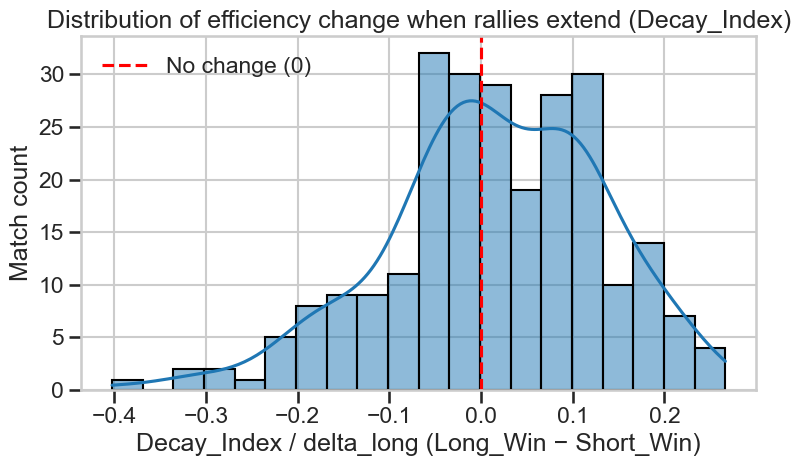

In [4]:
# Ensure we have all four win-rate buckets
required_cols = ["W_1_3", "W_4_6", "W_7_9", "W_10_plus"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected win-rate columns: {missing}")

# Construct short vs long aggregate win rates

df["Short_Win"] = df[["W_1_3", "W_4_6"]].mean(axis=1)
df["Long_Win"] = df[["W_7_9", "W_10_plus"]].mean(axis=1)

# Simple decay test at match level:
# delta_long = (7-9 W% + 10+ W%) / 2 - (1-3 W% + 4-6 W%) / 2
# This is algebraically identical to Long_Win − Short_Win.
df["delta_long"] = ((df["W_7_9"] + df["W_10_plus"]) / 2) - ((df["W_1_3"] + df["W_4_6"]) / 2)

# Decay_Index is kept as a named alias for delta_long
df["Decay_Index"] = df["delta_long"]

summary_decay = df["Decay_Index"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
display(summary_decay.to_frame(name="Decay_Index"))

mean_decay = df["Decay_Index"].mean()
print(f"\nMean Decay_Index (Long − Short) = {mean_decay*100:5.2f} percentage points")

# Plot distribution of Decay_Index / delta_long
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(df["Decay_Index"], bins=20, kde=True, ax=ax)
ax.axvline(0, color="red", linestyle="--", label="No change (0)")
ax.set_xlabel("Decay_Index / delta_long (Long_Win − Short_Win)")
ax.set_ylabel("Match count")
ax.set_title("Distribution of efficiency change when rallies extend (Decay_Index)")
ax.legend()
plt.tight_layout()
plt.show()

### Step 4 · Relationship between rally length and win probability

We test correlations between long-rally win rates and **average rally length**:

- `corr(W_7_9, RLen-Serve)` and `corr(W_7_9, RLen-Return)`.
- `corr(W_10_plus, RLen-Serve)` and `corr(W_10_plus, RLen-Return)`.

Interpretation:
- **Weak or positive** correlations → no evidence of efficiency decay as rallies get longer on average; possibly **comfort in longer exchanges**.
- **Strong negative** correlations → potential **fatigue or concentration loss** when the match environment forces longer rallies.

Correlation between long-rally win rates and rally length:
  win_rate_col rally_len_col  pearson_r
0        W_7_9    RLen-Serve      0.015
1        W_7_9   RLen-Return     -0.068
2    W_10_plus    RLen-Serve     -0.140
3    W_10_plus   RLen-Return     -0.063


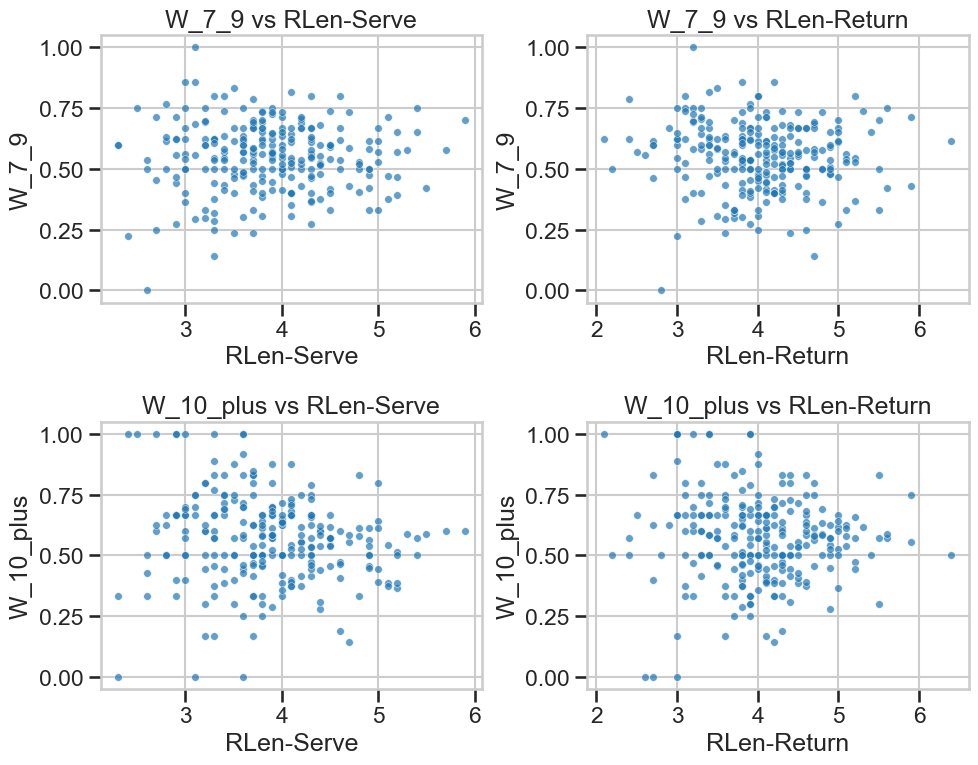

In [5]:
corr_pairs = []

for win_col in ["W_7_9", "W_10_plus"]:
    for rl_col in ["RLen-Serve", "RLen-Return"]:
        if win_col in df.columns and rl_col in df.columns:
            r = df[[win_col, rl_col]].corr().iloc[0, 1]
            corr_pairs.append({
                "win_rate_col": win_col,
                "rally_len_col": rl_col,
                "pearson_r": r,
            })

corr_df = pd.DataFrame(corr_pairs)

if not corr_df.empty:
    print("Correlation between long-rally win rates and rally length:")
    print(corr_df.assign(pearson_r=corr_df["pearson_r"].round(3)))
else:
    print("No correlation pairs computed – check column names.")

# Optional: quick scatter plots for visual intuition
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=False)
axes = axes.ravel()

plot_pairs = [
    ("W_7_9", "RLen-Serve"),
    ("W_7_9", "RLen-Return"),
    ("W_10_plus", "RLen-Serve"),
    ("W_10_plus", "RLen-Return"),
]

for ax, (win_col, rl_col) in zip(axes, plot_pairs):
    if win_col in df.columns and rl_col in df.columns:
        sns.scatterplot(data=df, x=rl_col, y=win_col, ax=ax, s=30, alpha=0.7)
        ax.set_xlabel(rl_col)
        ax.set_ylabel(win_col)
        ax.set_title(f"{win_col} vs {rl_col}")
    else:
        ax.text(0.5, 0.5, "Missing columns", ha="center", va="center")
        ax.set_axis_off()

plt.tight_layout()
plt.show()

### Distributional behavior · Extra-long rally efficiency (10+ W%)

We focus on **extra-long rallies (10+ shots)** and ask:

- How is `W_10_plus` distributed across matches?  
- How often does efficiency in 10+ shot rallies sit **well above, near, or below** 50% equilibrium?

We:
- Plot a **histogram of `W_10_plus`** (0–1 scale) and mark reference thresholds:
  - **0.50** (equilibrium), **0.60** (strong), **0.70** (dominant), **1.00** (perfect)
- Compute:
  - `(W_10_plus >= 0.70).mean()`  → share of matches with **dominant 10+ rally conversion**.  
  - `(W_10_plus == 1.00).mean()` → share of matches with **perfect 10+ conversion** (episodic dominance candidates).

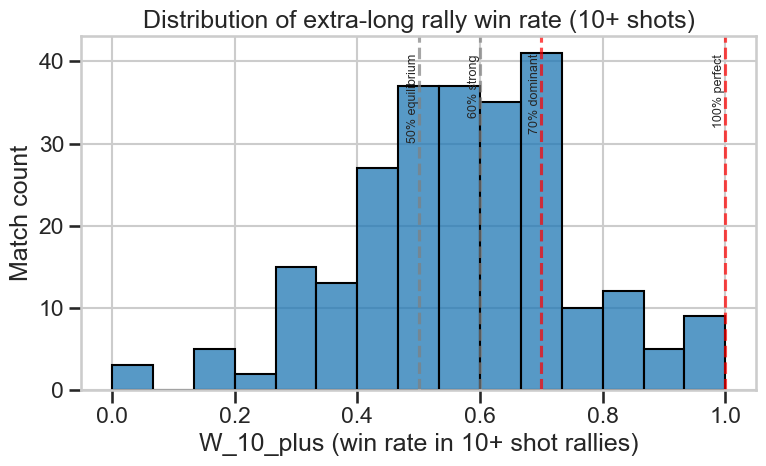

Share of matches with W_10_plus ≥ 70%: 19.92%
Share of matches with W_10_plus = 100%:  3.59%


In [6]:
if "W_10_plus" not in df.columns:
    raise ValueError("Column W_10_plus not found; check earlier parsing.")

series_10p = df["W_10_plus"].dropna()

fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(series_10p, bins=15, kde=False, ax=ax)

for thresh, label in [(0.50, "50% equilibrium"), (0.60, "60% strong"), (0.70, "70% dominant"), (1.00, "100% perfect")]:
    ax.axvline(thresh, color="red" if thresh >= 0.70 else "gray", linestyle="--", alpha=0.7)
    ax.text(thresh, ax.get_ylim()[1]*0.95, label, rotation=90, va="top", ha="right", fontsize=9)

ax.set_xlabel("W_10_plus (win rate in 10+ shot rallies)")
ax.set_ylabel("Match count")
ax.set_title("Distribution of extra-long rally win rate (10+ shots)")
plt.tight_layout()
plt.show()

share_dominant = (series_10p >= 0.70).mean()
share_perfect = (series_10p == 1.00).mean()

print(f"Share of matches with W_10_plus ≥ 70%: {share_dominant*100:5.2f}%")
print(f"Share of matches with W_10_plus = 100%: {share_perfect*100:5.2f}%")

### Distributional behavior · Episodic dominance (100% long-rally conversion)

We now identify matches where Alcaraz shows **episodic concentration dominance** in extra-long rallies:

- **Definition**: matches with `W_10_plus = 1.00` (perfect conversion in 10+ shot rallies).  
- These events likely arise from **small but meaningful sample sizes** (few 10+ rallies), so they do *not* imply universal dominance.

We will:
- List these matches with key context columns (match label, result, average rally lengths, win buckets).  
- Treat them as **case studies of peak sustained concentration**, not as population-level baselines.

In [7]:
# Identify matches with perfect 10+ conversion (episodic dominance candidates)

if "W_10_plus" not in df.columns:
    raise ValueError("Column W_10_plus not found; check earlier parsing.")

perfect_mask = df["W_10_plus"] == 1.0
perfect_df = df.loc[perfect_mask].copy()

print(f"Number of matches with W_10_plus = 100%: {perfect_df.shape[0]}")

context_cols = [
    col
    for col in [
        "Match",
        "Result",
        "RallyLen",
        "RLen-Serve",
        "RLen-Return",
        "W_1_3",
        "W_4_6",
        "W_7_9",
        "W_10_plus",
        "Short_Win",
        "Long_Win",
    ]
    if col in perfect_df.columns
]

if not perfect_df.empty:
    display(perfect_df[context_cols].sort_values(by="Match"))
else:
    print("No matches with perfect 10+ shot rally conversion.")

Number of matches with W_10_plus = 100%: 9


,Match,Result,RallyLen,RLen-Serve,RLen-Return,W_1_3,W_4_6,W_7_9,W_10_plus,Short_Win,Long_Win
192,2022 Cincinnati R32,W vs Mcdonald,3.5,3.0,3.9,0.576,0.714,0.400,1.0,0.6450,0.7000
160,2023 Madrid R16,W vs Zverev,3.2,3.6,3.0,0.556,0.731,0.625,1.0,0.6435,0.8125
148,2023 Queen's Club R16,W vs Lehecka,2.9,2.9,3.0,0.568,0.586,0.625,1.0,0.5770,0.8125
66,2024 Davis Cup RR,W vs Griekspoor,2.9,2.5,3.2,0.500,0.800,0.750,1.0,0.6500,0.8750
88,2024 Wimbledon F,W vs Djokovic,3.3,3.3,3.4,0.521,0.571,0.625,1.0,0.5460,0.8125
64,2025 Australian Open R64,W vs Nishioka,3.3,2.7,3.9,0.650,0.720,0.455,1.0,0.6850,0.7275
27,2025 Queen's Club F,W vs Lehecka,2.8,2.4,3.0,0.570,0.611,0.222,1.0,0.5905,0.6110
29,2025 Queen's Club QF,W vs Rinderknech,2.5,2.9,2.1,0.482,0.700,0.625,1.0,0.5910,0.8125
60,2025 Rotterdam R16,W vs Vavassori,3.5,3.6,3.4,0.625,0.654,0.600,1.0,0.6395,0.8000


### What this analysis claims / does not claim

**Claims**
- **Efficiency-shape focus**: The analysis evaluates whether **win probability decays toward 50%, remains stable, or improves** as rallies extend beyond 7 shots (via `W_7_9`, `W_10_plus`, and `Decay_Index`).
- **Match-level stability**: It quantifies **how consistent** that efficiency profile is across ≈250 matches (means, standard deviations, correlations).
- **Episodic dominance only**: 100% conversion in 10+ shot rallies is interpreted as **episodic concentration dominance**, not a baseline expectation.

**Does *not* claim**
- That Alcaraz is universally “better in long rallies” than in short ones.  
- That long-rally dominance is driven by any single factor (fitness, technique, tactics, psychology).  
- That these match-level aggregates capture point-by-point context (scoreline, surface, fatigue, opponent style, etc.).

Across ≈250 matches, **Alcaraz’s efficiency does not systematically decay as rally length increases**—the **shape of his win probability stays at or above equilibrium even in 10+ shot exchanges, with occasional episodes of near-perfect long-rally conversion.